In [11]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt
from  bfp import *
import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData
import seaborn as sns


In [12]:
from typing import Optional

def setup_solver(fe_space: mfem.FiniteElementSpace, rel_tol=1e-8, abs_tol=1e-10, max_iter=500) -> mfem.GMRESSolver:

    solver = mfem.GMRESSolver()
    solver.SetRelTol(rel_tol)
    solver.SetAbsTol(abs_tol)
    solver.SetMaxIter(max_iter)
    solver.SetPrintLevel(1)  # Çözüm ilerlemesi için detay seviyesi
    return solver


def setup_preconditioner(operator: mfem.Operator) -> mfem.DSmoother:

    M_prec = mfem.DSmoother()
    M_prec.SetOperator(operator)
    return M_prec


def solve_boltzmann(operator: mfem.Operator, rhs: mfem.Vector,
                    fe_space: mfem.FiniteElementSpace,
                    initial_guess: Optional[mfem.Vector] = None,
                    rel_tol=1e-8, abs_tol=1e-10,
                    max_iter=500) -> mfem.Vector:

    solver = setup_solver(fe_space, rel_tol, abs_tol, max_iter)
    prec = setup_preconditioner(operator)
    solver.SetPreconditioner(prec)
    solver.SetOperator(operator)

    solution = initial_guess if initial_guess else mfem.Vector(fe_space.GetVSize())
    solution.Assign(0.0)

    solver.Mult(rhs, solution)

    return solution


def save_solution(fe_space: mfem.FiniteElementSpace, solution: mfem.Vector, filename: str):

    grid_function = mfem.GridFunction(fe_space)
    grid_function.Assign(solution)
    grid_function.Save(filename)


In [13]:
# Set parameters
nx = 20
nE = 50
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.01
N_ang = 8
order = 1

mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
#set_boundary_attribute(mesh, -1, x_start, E_start, x_end, tol=1e-8)
"""
vertex_array = mesh.GetVertexArray()
for i in range(mesh.GetNBE()):
    v_indices = mesh.GetBdrElementVertices(i)
    idx0 = v_indices[0]
    vx = vertex_array[idx0][0]
    vE = vertex_array[idx0][1]
    attr = mesh.GetBdrAttribute(i)
    print(f"Boundary element {i}: Vertex = ({vx}, {vE}), Attribute = {attr}")
"""

fec = mfem.DG_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetVSize()
print("Number of unknowns:", Size)

#ess_bdr = mfem.intArray(mesh.bdr_attributes.Max())
#ess_bdr.Assign(0) 
#ess_bdr[0] = 1 # Left boundary,  Dirichlet condition.
#ess_bdr[1] = 1 # Right boundary

mu_vals, w_vals = gauss_legendre_dirs(N_ang)

#E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
S_arr = np.zeros(nE)
E_arr = np.linspace(E_start, E_end, nE+1)
xs_t_coeff = TotalXSCoefficient(4)
xs_s_coeff = ScatteringXSCoefficient(0)
S_coeff    = StoppingPowerCoefficient(0)
dS_dE_arr = np.zeros(nE)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(0)
q_coeff = ConstantCoefficient(50)
inflow_coeff = ConstantCoefficient(0)

File '/Users/melekderman/github/BFP/examples1/mesh/usr/20x50_2D.mesh' already exists.
Number of unknowns: 4000


In [14]:
#psi = mfem.GridFunction(fes)
#psi.Assign(1.0)
#psi.ProjectBdrCoefficient(inflow_coeff, ess_bdr)
psi_mu_list = []

for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    mu_coeff = ConstantCoefficient(mu)
    marker = get_marker_for_mu(mesh, mu)
    v_coeff = VelocityCoefficient2(mu, S_coeff)
    #v_coeff = VelocityCoefficientOld(mu, S_arr)
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    # Set up the linear form b for the RHS
    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, -1.0), marker)
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()


    solution = solve_boltzmann(operator=A, rhs=b, fe_space=fes)

    
    # Append the angular solution for mu
    psi_mu_list.append((mu, w, solution))
    
    # Save each angular solution and corresponding mesh.
    #solution.Save("psi_mu_list{:.3f}.gf".format(mu))

phi_new = mfem.GridFunction(fes)
phi_new.Assign(0.0)

for mu, w, psi in psi_mu_list:
    phi_new.Add(w, psi)

phi_new.Save("phi_newww.gf")
phi_plot = phi_new



  Solving for mu = -0.9602898564975362


TypeError: 'StoppingPowerCoefficient' object is not callable

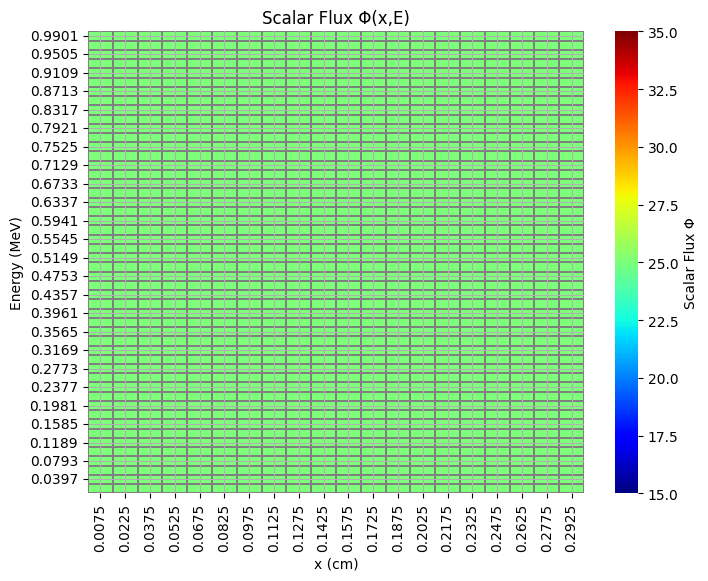

In [ ]:

HeatMap = HeatmapPlot(phi_new, mesh, fes)
HeatMap.plot_heatmap(x_start, x_end, nx, E_start, E_end, nE, vmin=15, vmax=35)

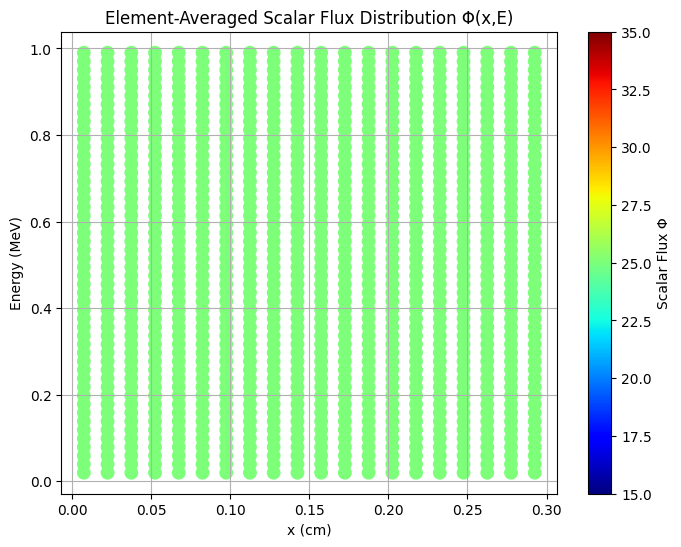

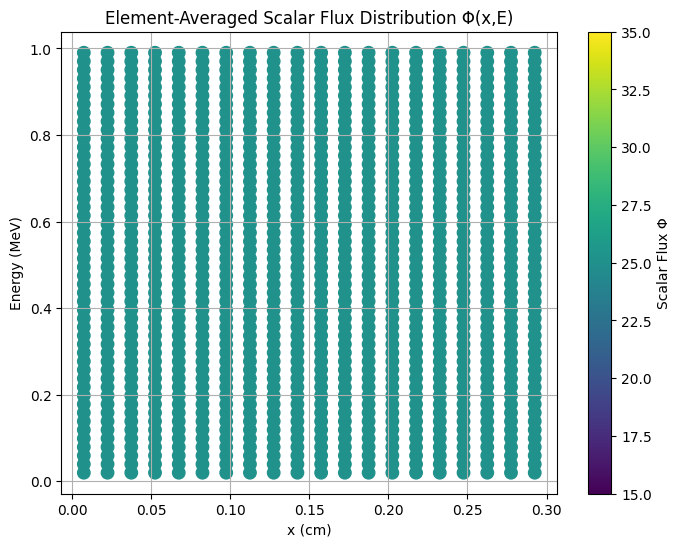

In [ ]:
Scatter = ScatterPlot(phi_new, mesh, fes)
Scatter.plot_scatter(point_size=80, vmin=15, vmax=35)
Scatter.plot_scatter(cmap='viridis', point_size=80, vmin=15, vmax=35)


In [16]:
sol = mfem.GridFunction(psi_mu_list[0][2])
glvis((mesh, sol), 400, 400)

IndexError: list index out of range